In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import timeit
import h5py
from pathlib import Path
import numpy as np
from itertools import product
import pickle
import scipy.special
import scipy.stats
from math import exp
import multiprocessing
import functools

from montecarlo import *

%matplotlib inline
np.seterr(all='warn')
textwidth = 6.268
mpl.rcParams['figure.dpi'] = 70
default_figargs = dict(figsize = (textwidth,textwidth))

from montecarlo import *

To check the sanity of the monte carlo routine, the above plot compares the boltzman factor $exp(-\beta F) $ for each state of a small system (N=6) with the number of occurances seen during a monte carlo run. Each column shows these factors after an increasing number of montecarlo steps. Each row represents the states by a differnt measure, first they're simply ordered by increasing free energy, second they're plotted against free energy so that degernate states clump together. The 3rd and 4th show the overall occupation $Nf + Nc$ and the squared staggered magnetisation. 

The above plot shows the mean of each observable after x monte carlo steps, showing gradual convergence. Currently the Ff, Fc and Nc observables don't converge to the correct values!

In [23]:
#%%time
from time import time
from montecarlo import *
from general import index_histogram

class Eigenspectrum_IPR(object):
    def __init__(self, bins = 70, limit = 5):
        self.eigenval_bins = np.linspace(-limit, limit, bins + 1)
    
    def start(self, N_steps, N_sites):
        self.N_steps = N_steps
        self.eigenvals = np.zeros((N_steps,N_sites), dtype = np.float64)
        self.eigenval_histogram = np.zeros((N_steps,self.eigenval_bins.shape[0]-1), dtype = np.float64)
        self.IPR_histogram = np.zeros((N_steps,self.eigenval_bins.shape[0]-1), dtype = np.float64)

    def update(self, j, Ff, Fc, state, evals, evecs, mu, beta, J_matrix, **kwargs):
        IPRs = ((evecs * np.conj(evecs))**2).sum(axis = 0)
        self.eigenval_histogram[j], _, indices = index_histogram(self.eigenval_bins, evals)
        self.IPR_histogram[j] = np.bincount(indices, weights=IPRs, minlength = self.eigenval_bins.shape[0] + 1)[1:-1]

    
    def return_vals(self):
        E_histogram = np.mean(self.eigenval_histogram, axis = 0)
        normalisation_factor = np.sum(E_histogram)
        
        E_histogram = E_histogram / normalisation_factor 
        dE_histogram = scipy.stats.sem(self.eigenval_histogram, axis = 0) / normalisation_factor
        
        IPR_histogram, dIPR_histogram = np.mean(self.IPR_histogram, axis = 0), scipy.stats.sem(self.IPR_histogram, axis = 0)
        
        return self.eigenval_bins, E_histogram, dE_histogram, IPR_histogram, dIPR_histogram

parameters = dict(t = t, alpha = alpha, mu = 0, beta = 1/1.1, J = 5, U = 5, normalise = True)

MCMC_params = dict(
        N_steps = int(1 * 1000),
        N_burn_in = int(0.1 * 1000), 
        state=np.arange(50) % 2, 
        logger = Eigenspectrum_IPR(bins = 200, limit = 5),
        proposal = p_multi_site_uniform_reflect,
        #proposal_args = dict(lam = 4),
        accept_function = simple_accept,
    )

bins, E, dE, IPR, dIPR = FK_mcmc_2(parameters = parameters, **MCMC_params)

Warning, p_acc = 0.02158181818181818, {'t': 1, 'alpha': 1.5, 'mu': 0, 'beta': 0.9090909090909091, 'J': 5, 'U': 5, 'normalise': True, 'J_matrix': 'suppressed for brevity'}


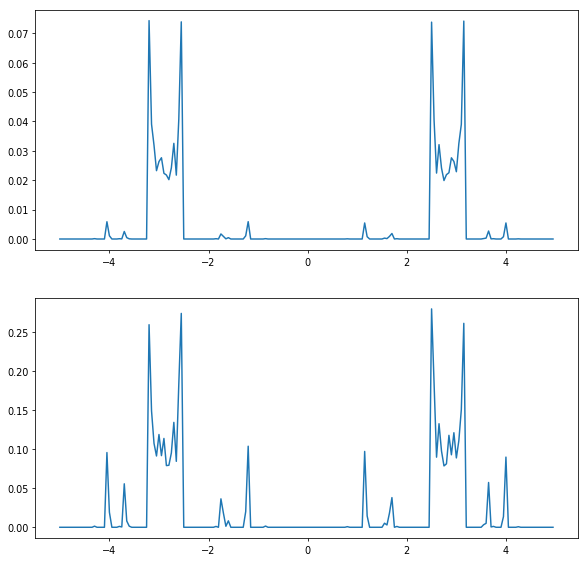

In [24]:
f, (Eax, Iax) = plt.subplots(2,1, figsize  = (10,10))
Eax.plot(bins[:-1], E)
Iax.plot(bins[:-1], IPR)